# Imports

In [1]:
#General
import re
import os
import math
import random
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

#XML parsing
from xml.etree import ElementTree

#Model
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

#Testing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split

#Feature Union
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion

#NLTK
import nltk
from nltk import word_tokenize
from nltk import TweetTokenizer
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Parsers
## XML Parser for NPSCHATCORPUS
Custom build XML parser, created for loading the NPSCHATCORPUS.

In [2]:
#Initialize Dataframe
df_NPS = pd.DataFrame(columns = ["Text", "Label"])

#XML Parser for NPSCHAT CORPUS
folder_path = "../npsChat/XML Files"
XML_files = os.listdir(folder_path)
for f in XML_files:
    file_name = "../npsChat/XML Files/" + f
    Tree = ElementTree.parse(file_name)
    session = Tree.getroot()
    for Posts in session:
        for post in Posts:
            Utt_Class = (post.attrib["class"])
            Utt_text = post.text
            new_Row = {"Text": Utt_text, "Label": Utt_Class}
            df_NPS = df_NPS.append(new_Row, ignore_index = True)

# Pre-processing for SVM

In [3]:
# # Removing system label
# df_NPS = df_NPS[df_NPS['Label'] != 'System']
# df_NPS.reset_index(drop = True, inplace = True)

## Feature Union

In [4]:
#--- init OneHotEncoders
ohe = OneHotEncoder(sparse = True) 
ohe_FW = OneHotEncoder(sparse = True)

def to_Matrix (X):
    return [X]

#Featurizer 1 
class FeaturizerLength(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        utt_List = X.tolist()
        d = []
        bins = np.arange(1, 170, 10).tolist()
        bin_name = np.arange(1,18,1).tolist()          #Changed to fewer bins than SVM_Reddit_Optimized, due to compatability reasons
        for utt in utt_List:
            utt_len = len(utt)
            if utt_len > 170:
                placeholder = 18
            else:
                placeholder = (np.digitize(utt_len,bins=bins, right=False)).tolist()
            d.append(to_Matrix(placeholder))
        return ohe.fit_transform(d)
    


    def get_feature_names(self):
        return ohe.categories_


#Featurizer 2 
class FeaturizerFirstWord(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        cont_Words = {"and", "but" , "or", "while","me", "also", "anyways", "thus", "hence", "so", "because"}
        utt_List = X.tolist()
        fwList = []
        for utt in utt_List:
            if " " in utt:
                placeholder = utt.split(" ")[0].lower()
                if placeholder in cont_Words:
                    fwList.append(to_Matrix(1))
                else:
                    fwList.append(to_Matrix(0))
            else:
                if utt in cont_Words:
                    fwList.append(to_Matrix(1))
                else:
                    fwList.append(to_Matrix(0))
        return fwList

    def get_feature_names(self):
        return ohe_FW.categories_

## Sample Smoothing

In [5]:
#Rob van der Goot, Ahmet ̈Ust ̈un, Alan Ramponi, andBarbara Plank. 2020a. MaChAmp proportional sam-pling. https://github.com/machamp-nlp/machamp/blob/master/machamp/modules/bucket_batch_sampler.py

def sample_smoothing(dataframe, sampling_smoothing):

    distribution = dataframe.groupby(dataframe['Label']).count()['Text']
    labels = dataframe['Label'].unique().tolist()
    labels.sort()

    if sampling_smoothing != 1.0:
        all_batches = []
        df_sorted = dataframe.sort_values(by='Label')

        for label in labels:
            df_Batch = df_sorted[df_sorted['Label'] == label]
            batch = df_Batch.values.tolist()
            all_batches.append(batch)


        sizes = distribution.tolist()
        total_size = sum(sizes)

        # calculate new size based on smoothing
        new_sizes = []
        total_new_prob = 0.0
        for size in sizes:
            pi = size/total_size
            total_new_prob += math.pow(pi, sampling_smoothing)

        for size in sizes:
            pi = size/total_size
            prob = (1/pi) * (math.pow(pi, sampling_smoothing)/total_new_prob)
            new_sizes.append(int(size * prob))
        # print(new_sizes)

        # collect all batches
        this_epoch_all_batches = []
        for dataset_idx in range(len(sizes)):
            new_size = new_sizes[dataset_idx]
            while new_size > len(all_batches[dataset_idx]):
                all_batches[dataset_idx] += all_batches[dataset_idx]
            this_epoch_all_batches += all_batches[dataset_idx][:new_size]

        # shuffle all batches
        random.seed(1)
        random.shuffle(this_epoch_all_batches)
        # recreate dataframe
        return pd.DataFrame(this_epoch_all_batches, columns=['Text', 'Label'])

    else: 
        return dataframe

## Tokenization

In [6]:
nltk.download('punkt')

def twitter_Tok(document):
    twitternize = TweetTokenizer()
    tokens = twitternize.tokenize(document)
    return (tokens)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nikol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Custon pre-processing

In [7]:
porter_stemmer=PorterStemmer()

def custom_Preproccesing(text):
    text = re.sub('(\S*User\S*)','[User]', text) # generalize usernames
    words=re.split("\\s+",text)
    stemmed_words=[porter_stemmer.stem(word=word) for word in words]

    return ' '.join(stemmed_words)

# Model name: Support Vector Machine (SVM)

In [8]:
train, test = train_test_split(df_NPS, train_size=0.80, test_size=0.20, random_state=101)

In [9]:
train_sampled = sample_smoothing(train, 0.64) # Change to any value between 1.0 and 0.0

X_train = train_sampled['Text']
y_train = train_sampled['Label']

X_test = test['Text']
y_test = test['Label']

In [10]:
Featureizer = FeatureUnion([
    ("TdifVecWord", TfidfVectorizer(tokenizer=twitter_Tok, binary=True, ngram_range=(1,1))),
    ("TdifVecChar", TfidfVectorizer(tokenizer=twitter_Tok, binary=True, ngram_range=(2,3), analyzer="char_wb")),
    # ("VecLen",FeaturizerLength()),
    ("VecFirstWord", FeaturizerFirstWord()),
])
Featureizer.fit_transform(X_train)
X_train_vectorized = Featureizer.transform(X_train)
X_test_vectorized = Featureizer.transform(X_test)
print(X_train_vectorized.shape)
print(X_test_vectorized.shape)

(8448, 12394)
(2114, 12394)


In [11]:
rbf_nps = svm.SVC(kernel='rbf', gamma='scale', C=4).fit(X_train_vectorized, y_train)
rbf_pred = rbf_nps.predict(X_test_vectorized)

# Confussion Matrix for SVM

Accuracy (RBF Kernel):  84.15
F1 (RBF Kernel):  83.57


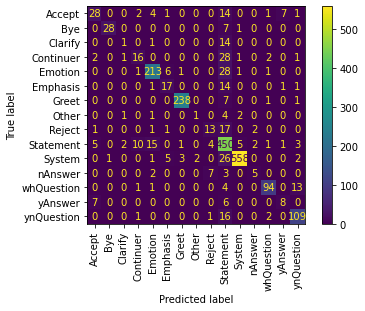

In [12]:
rbf_accuracy = accuracy_score(y_test, rbf_pred)
rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))
plot_confusion_matrix(rbf_nps, X_test_vectorized, y_test, xticks_rotation = 'vertical')
plt.show()

In [13]:
# grid_param = [
#     {
#     'C': [3,5,7,9,11],
#     'gamma': ['scale', 0.1, 0.05, 0.01, 0.005],
#     'kernel': ['rbf']},
# ]

# optimal_params = GridSearchCV(
#     svm.SVC(),
#     grid_param,
#     cv = 5,
#     scoring = 'accuracy',
#     verbose = 0)

# optimal_params.fit(X_train_vectorized, y_train)
# print(optimal_params.best_score_)
# print(optimal_params.best_params_)